In [1]:
from bdb2026.data_io import load_bdb_csvs_from_kaggle_download
from bdb2026.preprocess import (add_postthrow_features, merge_route_embeddings, normalize_coordinates, 
                                add_postthrow_features,select_target_receiver_rows,filter_to_completed_catches,
                                attach_output_labels,compute_initial_separation_at_throw, add_converge_rate_from_labels,)
from bdb2026.routes import cluster_routes_kmeans, make_route_embedding_table, engineer_route_features
from bdb2026.sequences import build_sequences
from bdb2026.models import build_lstm, train_lstm
from bdb2026.metrics import compute_truespeed, compute_route_execution_score, build_truespeed_scorecard
from bdb2026.viz import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_input, df_output, df_supp = load_bdb_csvs_from_kaggle_download(
    kaggle_root_dir=r"C:\Users\rajas\Documents\VS_Code\Big_Data_Bowl\114239_nfl_competition_files_published_analytics_final",
    supplementary_csv=r"C:\Users\rajas\Documents\VS_Code\Big_Data_Bowl\114239_nfl_competition_files_published_analytics_final\supplementary_data.csv",
)

In [3]:
df_in = normalize_coordinates(df_input)
sep = compute_initial_separation_at_throw(df_in)

df_wr_target = select_target_receiver_rows(df_in)              
df_wr_target = filter_to_completed_catches(df_wr_target, df_supp)
df_wr_target = df_wr_target.merge(sep, on=["game_id","play_id","nfl_id"], how="left")

df_post = add_postthrow_features(df_wr_target)               # ONLY one argument (your current API)
df_post = attach_output_labels(df_post, df_output) 
df_post = add_converge_rate_from_labels(df_post) 

In [4]:
# Build route features on the pre-throw window (targeted receiver), then cluster
df_routes = engineer_route_features(df_wr_target)
df_routes = df_routes[df_routes["route_frames"] >= 5].copy() # only cluster on routes with at least 5 frames
route_result = cluster_routes_kmeans(df_routes, n_clusters=12)
route_emb = make_route_embedding_table(route_result.assignments, n_clusters=12, prefix='route_emb')

# merge the static embedding columns
df_features = merge_route_embeddings(df_post, route_emb)

In [5]:
# Include route_emb_* columns in feature_cols when building LSTM tensors
feature_cols = [
    # Position
    'x_norm', 'y_norm',
    # Motion
    'dx', 'dy', 'speed',
    # Geometry
    'dist_to_land', 'bearing_to_land', 'heading', 'heading_align_cos',
    # Temporal
    'time_since_throw',
    # Context (constant per play)
    'initial_separation', 'ball_land_x_norm', 'ball_land_y_norm'
    # 'defender_separation' removed - will use in Phase 3 for context scoring
]  + [c for c in df_features.columns if c.startswith('route_emb_')]

X, y, keys = build_sequences(
    df_features,
    feature_cols=feature_cols,
    target_col="converge_rate",
    max_len=25
)

In [6]:
model = build_lstm(n_features=X.shape[-1], hidden_units=64, dropout=0.2, mask_value=0.0)
result = train_lstm(model, X, y, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 27.4451 - mae: 4.3517 - learning_rate: 0.0010
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.7391 - mae: 4.3020 - learning_rate: 0.0010
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 26.1072 - mae: 4.2530 - learning_rate: 0.0010
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 25.4761 - mae: 4.2057 - learning_rate: 0.0010
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 24.8800 - mae: 4.1598 - learning_rate: 0.0010
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 24.2842 - mae: 4.1150 - learning_rate: 0.0010
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 23.6379 - mae: 4.0713 - learning_rate: 0.0010
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 23.1741 - mae: 4.0290 - learning_rate: 0.0010
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22.6234 - mae: 3.9878 - learning_rate: 0.0010
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - l

In [7]:
# Predict + compute TrueSpeed per play
y_hat = result.model.predict(X)
df_pred = (
    pd.DataFrame(keys, columns=["game_id","play_id"])
      .assign(idx=np.arange(len(keys)))
      .merge(
          pd.DataFrame({
              "idx": np.repeat(np.arange(len(keys)), X.shape[1]),
              "t": np.tile(np.arange(X.shape[1]), len(keys)),
              "actual": y.reshape(-1),
              "pred": y_hat.reshape(-1),
          }),
          on="idx",
      )
)
df_pred['residual'] = df_pred['actual'] - df_pred['pred']
ts = compute_truespeed(df_pred, actual_col="actual", pred_col="pred", id_cols=("game_id","play_id"), agg="mean")
ts.head()

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,game_id,play_id,TrueSpeed
0,2023090700,361,0.426835
1,2023090700,436,-0.742021
2,2023090700,461,0.407429
3,2023090700,530,-1.522066
4,2023090700,621,0.198801


In [8]:
df_pred.head()

,game_id,play_id,idx,t,actual,pred,residual
0,2023090700,361,0,0,0.000000,1.564058,-1.564058
1,2023090700,361,0,1,0.321365,1.564058,-1.242692
2,2023090700,361,0,2,0.799144,1.564058,-0.764914
3,2023090700,361,0,3,1.364456,1.564058,-0.199602
4,2023090700,361,0,4,1.914580,1.564058,0.350522


In [9]:
# 1) play-level TrueSpeed from residuals
truespeed_play = compute_truespeed(
    df_pred,
    actual_col="actual",
    pred_col="pred",   # set to your model output col
    id_cols=("game_id", "play_id"),
    agg="mean",
    out_col="TrueSpeed",
)

# 2) play-level RouteExecution score (requires route clustering artifacts)
route_exec_play = compute_route_execution_score(
    route_features=df_routes,                 # output of engineer_route_features(...)
    assignments=route_result.assignments,     # from cluster_routes_kmeans(...)
    centroids=route_result.centroids,         # from cluster_routes_kmeans(...)
    feature_cols=route_result.centroids.columns.drop("route_cluster").tolist(),
    id_cols=("game_id", "play_id"),
)
print(route_exec_play.columns)

# 3) player-level table matching your CSV

df_scorecard = build_truespeed_scorecard(
    truespeed_play=truespeed_play,
    route_exec_play=route_exec_play,
    df_input=df_input,
    df_supp=df_supp,
    volume_threshold_ratio=0.50,
    junk_routes=("SCREEN","FLAT","ANGLE","WHEEL","SHIELD"),
)

df_scorecard.to_csv("TrueSpeed.csv", index=False)

Index(['game_id', 'play_id', 'RouteExecution'], dtype='object')


In [10]:
route_exec_play.head()

,game_id,play_id,RouteExecution
0,2023090700,361,23.6
1,2023090700,436,3.7
2,2023090700,461,6.0
3,2023090700,530,3.6
4,2023090700,621,1.9


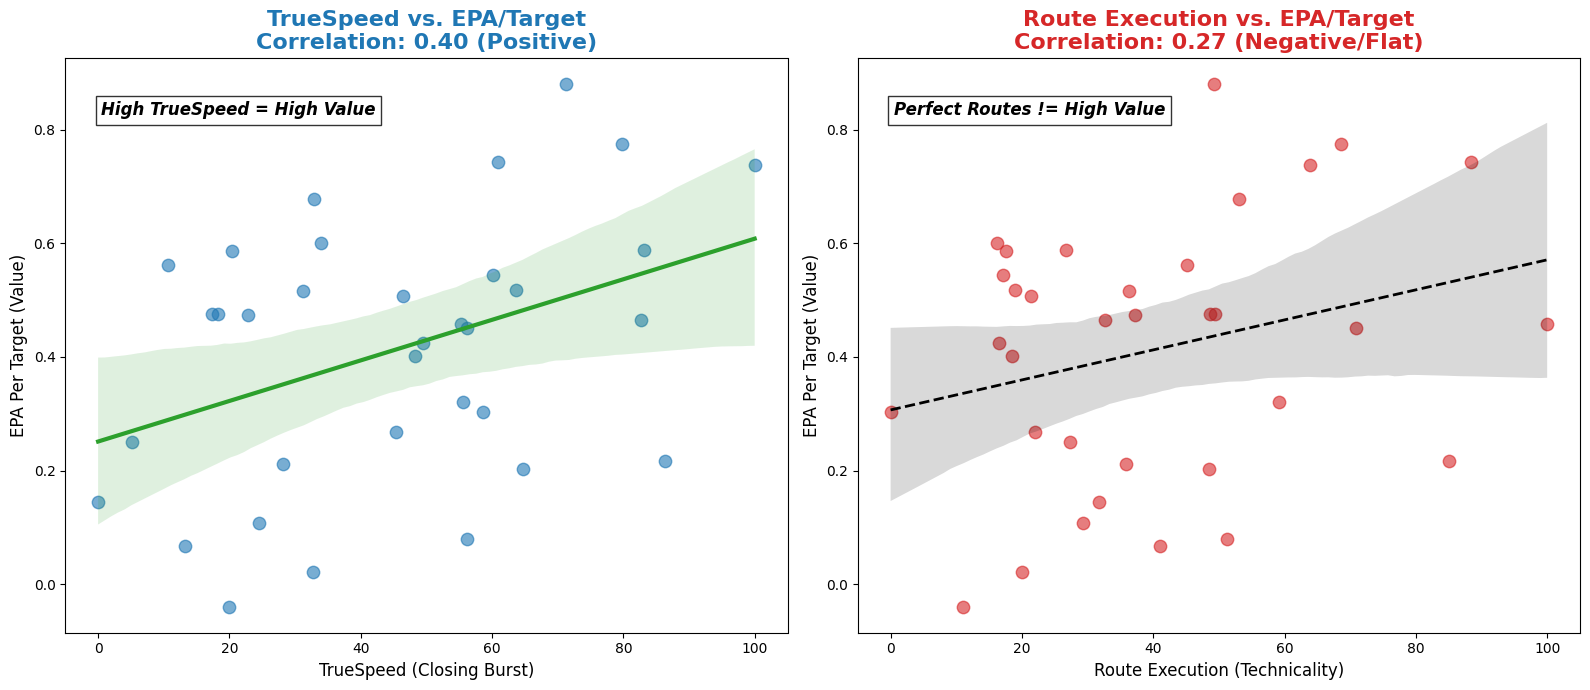

In [13]:
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import seaborn as sns
df= df_scorecard.copy()
# Clean Data
cols_to_numeric = ['TrueSpeed', 'RouteExecution', 'EPA_Per_Target']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df.dropna(subset=cols_to_numeric)

# Setup Figure
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: TrueSpeed vs EPA ---
sns.regplot(
    x='TrueSpeed', 
    y='EPA_Per_Target', 
    data=df_clean, 
    ax=axes[0], 
    color='#1f77b4', # Blue
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color': '#2ca02c', 'linewidth': 3}
)

corr_ts, _ = pearsonr(df_clean['TrueSpeed'], df_clean['EPA_Per_Target'])

axes[0].set_title(f"TrueSpeed vs. EPA/Target\nCorrelation: {corr_ts:.2f} (Positive)", fontsize=16, weight='bold', color='#1f77b4')
axes[0].set_xlabel("TrueSpeed (Closing Burst)", fontsize=12)
axes[0].set_ylabel("EPA Per Target (Value)", fontsize=12)
#axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].text(0.05, 0.9, "High TrueSpeed = High Value", transform=axes[0].transAxes, fontsize=12, style='italic', weight='bold', bbox=dict(facecolor='white', alpha=0.8))


# --- Plot 2: Route Execution vs EPA ---
sns.regplot(
    x='RouteExecution', 
    y='EPA_Per_Target', 
    data=df_clean, 
    ax=axes[1], 
    color='#d62728', # Red for 'Warning'
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color': 'black', 'linewidth': 2, 'linestyle': '--'}
)

corr_re, _ = pearsonr(df_clean['RouteExecution'], df_clean['EPA_Per_Target'])

axes[1].set_title(f"Route Execution vs. EPA/Target\nCorrelation: {corr_re:.2f} (Negative/Flat)", fontsize=16, weight='bold', color='#d62728')
axes[1].set_xlabel("Route Execution (Technicality)", fontsize=12)
axes[1].set_ylabel("EPA Per Target (Value)", fontsize=12)
#axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].text(0.05, 0.9, "Perfect Routes != High Value", transform=axes[1].transAxes, fontsize=12, style='italic', weight='bold', bbox=dict(facecolor='white', alpha=0.8))

# Main Title
#plt.suptitle("The Market Inefficiency: Athleticism Trumps Technique", fontsize=20, weight='bold', y=1.05)

plt.tight_layout()
plt.savefig("market_inefficiency_correlations.png")
plt.show()

In [ ]:
fig = plot_market_inefficiency_correlation(
    scorecard,
    x_col="TrueSpeed",
    y_col="EPAPerTarget",
    label_col="PlayerName",
    title="Market inefficiency: TrueSpeed vs EPA/Target",
)
fig


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('<b>%{hovertext}</b><br><br>Tru' ... 'yerName=%{text}<extra></extra>'),
              'hovertext': array(['Marvin Jones', 'Amon-Ra St. Brown', 'Josh Reynolds', 'Justin Watson',
                                  'Marquez Valdes-Scantling', 'Rashee Rice', 'Richie James',
                                  'Kalif Raymond', 'Justyn Ross', 'Terrace Marshall Jr.', 'Mack Hollins',
                                  'Adam Thielen', 'Jonathan Mingo', 'Zay Flowers', 'Rashod Bateman',
                                  'Robert Woods', 'Nico Collins', 'Tank Dell', 'Odell Beckham',
                                  'Noah Brown', 'Xavier Hutchinson', "Ja'Marr Chase", 'Tyler Boyd',
                                  'Amari Cooper', 'Donovan Peoples-Jones', 'Elijah Moore', 'Josh Downs',
                                  'Christian Kirk', 'Calvin Ridley', 'Zay Jones', 'Alec Pierce',
                                  'Michael Pittman', 'Justin Jefferson', 'Chris Godwin Jr.',
                                  'Jordan Addison', 'K.J. Osborn', 'Mike Evans', 'Deven Thompkins',
                                  'Trey Palmer', 'Michael Thomas', 'DeAndre Hopkins',
                                  'Nick Westbrook-Ikhine', 'Chris Olave', 'Rashid Shaheed',
                                  'Treylon Burks', 'George Pickens', 'Deebo Samuel Sr.', 'Brandon Aiyuk',
                                  'Allen Robinson', 'Diontae Johnson', 'Calvin Austin III',
                                  'Jahan Dotson', 'Curtis Samuel', 'Rondale Moore', 'Terry McLaurin',
                                  'Marquise Brown', 'Michael Wilson', 'Tyler Scott', 'Romeo Doubs',
                                  'Darnell Mooney', 'DJ Moore', 'Samori Toure', 'Jayden Reed',
                                  'Davante Adams', 'Jakobi Meyers', 'Brandon Johnson',
                                  "Lil'Jordan Humphrey", 'Courtland Sutton', 'Marvin Mims Jr.',
                                  'Jaylen Waddle', 'Keenan Allen', 'River Cracraft', 'Braxton Berrios',
                                  'Tyreek Hill', 'Josh Palmer', 'Quentin Johnston', 'Mike Williams',
                                  'Quez Watkins', 'A.J. Brown', 'DeVonta Smith', 'Kendrick Bourne',
                                  'JuJu Smith-Schuster', 'DeMario Douglas', 'Ty Montgomery',
                                  'Tyler Lockett', 'DK Metcalf', 'Van Jefferson', 'Puka Nacua',
                                  'Jaxon Smith-Njigba', 'Tutu Atwell', 'CeeDee Lamb', 'KaVontae Turpin',
                                  'Brandin Cooks', 'Michael Gallup', 'Darius Slayton', 'Isaiah Hodgins',
                                  'Parris Campbell', 'Stefon Diggs', 'Garrett Wilson', 'Deonte Harty',
                                  'Allen Lazard', 'Gabe Davis', 'Drake London', 'Dontayvion Wicks',
                                  'Khalil Shakir', 'Hunter Renfrow', 'Nelson Agholor', 'Tee Higgins',
                                  'Antoine Green', 'Jake Bobo', 'John Metchie III', 'Skyy Moore',
                                  'Kadarius Toney', 'Jamal Agnew', 'Chase Claypool', 'Rakim Jarrett',
                                  'Jalin Hyatt', 'Zach Pascal', 'Sterling Shepard', 'Jauan Jennings',
                                  'Ben Skowronek', 'Jalen Tolbert', 'Mecole Hardman', 'Jerry Jeudy',
                                  'Dyami Brown', 'Byron Pringle', 'DeVante Parker', 'D.J. Chark',
                                  'David Bell', 'Gunner Olszewski', 'Miles Boykin', "Wan'Dale Robinson",
                                  'Ronnie Bell', 'Isaiah McKenzie', 'Chris Moore', 'KhaDarel Hodge',
                                  'Tim Jones', 'Robbie Chosen', 'Derius Davis', 'Brandon Powell',
                                  'Randall Cobb', 'Trent Sherfield', 'Olamide Zaccheaus', 'Charlie Jones',
                                  'Christian Watson', 'Cedrick Wilson Jr.', 'Equanimeous St. Brown',
             